In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from   datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from   torch.utils.data import DataLoader, TensorDataset
import ot
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from matplotlib.collections import LineCollection


 ### 1. Experimental Parameters



 All key parameters for the experiment are defined here.

In [14]:
# --- Data Parameters ---
N_TRAIN = 1000            # Number of samples to train on
N_TRUTH = 50000          # Number of "ground truth" samples for evaluation
N_GEN = 20000            # Number of samples to generate from the model

# --- Model & Schedule Parameters ---
T = 200                  # Number of diffusion steps
SCHEDULE_S = 0.008       # Offset for cosine schedule

# --- Training Parameters ---
N_EPOCHS = 1000          # Increase epochs for the small dataset
BATCH_SIZE = 32          # Batch size (must be <= N_TRAIN)
LR = 1e-3                # Learning rate

# --- Trajectory/Misc Parameters ---
START_NOISE_VEC = torch.tensor([[-0.4, -0.2]]) # Fixed start for trajectory plots
N_TRAJ_RUNS = 2          # Number of stochastic trajectories to plot

# --- Output ---
run_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir    = f"run_{run_timestamp}"
os.makedirs(output_dir, exist_ok=True)
print(f"Created output directory: {output_dir}")


Created output directory: run_20251110_101010


 ### 2. Phase 1: Data Generation



 Define the 3-circle generator and create two distinct datasets:

 1.  `X_truth_tensor`: A large (50k) set representing the "ground truth" distribution. Used *only* for evaluation.

 2.  `X_train_tensor`: A tiny (100) set for the model to train on.

In [15]:
# --- Define the three circles dataset generator ---
circles = {
    1: (np.array([ 2.0,  0.0]), 1.0),   # circle 1 at (2,0), radius 1
    2: (np.array([-2.0, -3.0]), 2.0),   # circle 2 at (-2,-3), radius 2
    3: (np.array([-3.0,  4.0]), 3.0)    # circle 3 at (-3,4), radius 3
}
choices = [1, 2, 2, 3, 3, 3] # weighting 1:2:3

def G():
    """Generate one uniformly random point on the perimeter of a weighted circle."""
    cid = np.random.choice(choices)
    theta = np.random.uniform(0, 2*np.pi)
    center, r = circles[cid]
    x = center[0] + r * np.cos(theta)
    y = center[1] + r * np.sin(theta)
    return (x, y), cid

def generate_data(N):
    """Generates N samples from the 3-circles generator."""
    samples_list, labels_list = zip(*(G() for _ in range(N)))
    X_np = np.array(samples_list)
    X_tensor = torch.tensor(X_np, dtype=torch.float32)
    return X_np, X_tensor, np.array(labels_list)

# --- Generate the two datasets ---
X_truth_np, X_truth_tensor, _ = generate_data(N_TRUTH)
X_train_np, X_train_tensor, _ = generate_data(N_TRAIN)

print(f"Ground Truth Dataset Shape: {X_truth_tensor.shape}")
print(f"Training Dataset Shape:     {X_train_tensor.shape}")


Ground Truth Dataset Shape: torch.Size([50000, 2])
Training Dataset Shape:     torch.Size([1000, 2])


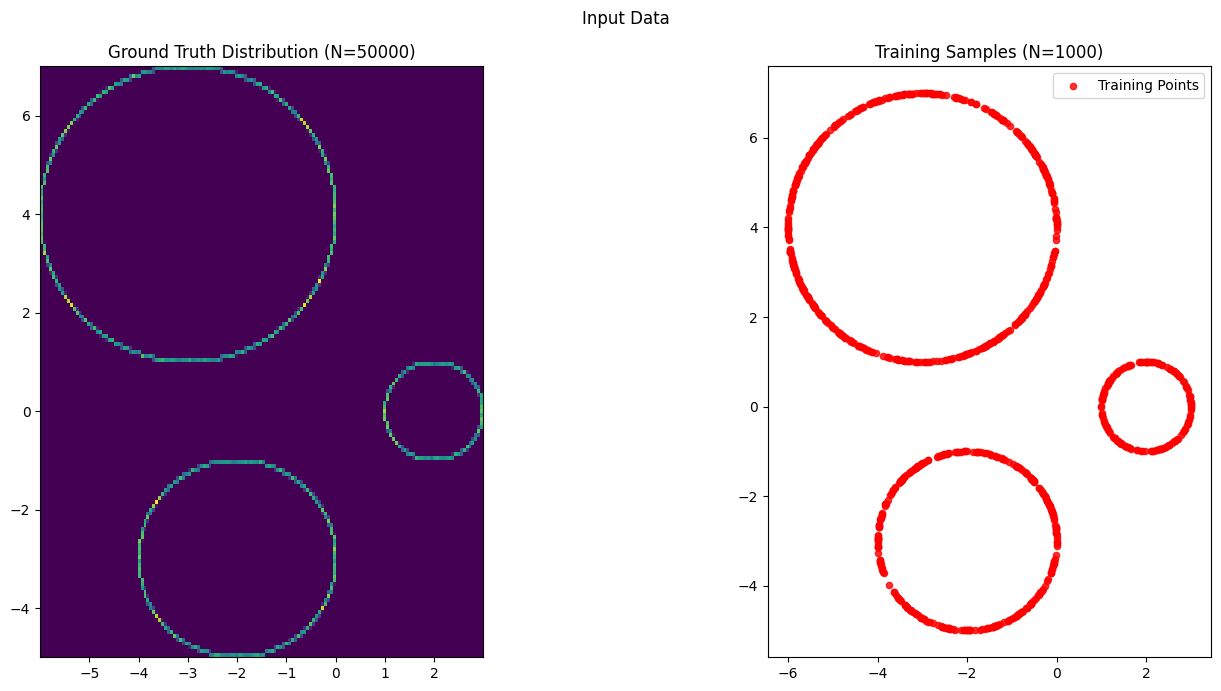

In [16]:
# --- Visualize the source and training data ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle("Input Data")

# Plot 1: Ground Truth Distribution (Histogram)
ax1.hist2d(X_truth_np[:,0], X_truth_np[:,1], bins=150, density=True, cmap='viridis')
ax1.set_title(f"Ground Truth Distribution (N={N_TRUTH})")
ax1.set_aspect('equal')

# Plot 2: Training Data (Scatter)
ax2.scatter(X_train_np[:,0], X_train_np[:,1], s=20, alpha=0.8, c='r', label='Training Points')
ax2.set_title(f"Training Samples (N={N_TRAIN})")
ax2.set_aspect('equal')
ax2.legend()

plt.tight_layout()
plt.show()


 ### 3. Model & Schedule Definitions



 Define the `DenoiseMLP` model and the noise schedule functions.

In [17]:
def cosine_beta_schedule(T, s=0.008):
    """Cosine schedule from https://arxiv.org/abs/2102.09672"""
    steps = T + 1
    x = torch.linspace(0, T, steps)
    alphas_cumprod = torch.cos(((x / T) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clamp(betas, 0.0001, 0.9999).float()

def get_schedules(schedule_type, T):
    """Returns beta, alpha, and alpha_bar for a given schedule."""
    if schedule_type == 'linear':
        beta = torch.linspace(1e-4, 0.02, T)
    elif schedule_type == 'cosine':
        beta = cosine_beta_schedule(T, s=SCHEDULE_S)
    else:
        raise ValueError(f"Unknown schedule_type: {schedule_type}")
        
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    return beta, alpha, alpha_bar


In [18]:
class DenoiseMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2+1, 128)  # +1 for time embedding
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)
    
    def forward(self, x, t): # t is normalized time
        # Normalize t
        t_norm = t / T
        t_embed = t_norm.unsqueeze(-1)
        h = torch.cat([x, t_embed], dim=1)
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        return self.fc3(h)


 ### 4. Sampling & Evaluation Functions



 Define helper functions to:

 1.  `sample`: Generate new data from a trained model.

 2.  `evaluate_distributions`: Create all plots and calculate all metrics.

 3.  `plot_stochastic_trajectories`: Plot the N-run trajectory experiment.

In [19]:
@torch.no_grad()
def sample(model, n_samples, T, alpha, alpha_bar, beta):
    """Generates n_samples from the trained model."""
    x = torch.randn(n_samples, 2)  # start from pure noise
    snapshots = {}
    
    num_snapshots = min(9, T)
    snapshot_timesteps = np.unique(np.round(np.linspace(0, T - 1, num_snapshots)).astype(int)).tolist()    
    snapshot_timesteps = snapshot_timesteps[::-1]
    
    model.eval()
    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, dtype=torch.float32)
        predicted_noise = model(x, t_batch)
        
        alpha_t = alpha[t]
        alpha_bar_t = alpha_bar[t]
        beta_t = beta[t]
        
        x = 1/torch.sqrt(alpha_t) * (x - (1-alpha_t)/torch.sqrt(1-alpha_bar_t)*predicted_noise)
        
        if t > 0:
            x += torch.sqrt(beta_t) * torch.randn_like(x)

        if t in snapshot_timesteps:
            snapshots[int(t)] = x.clone().detach().cpu()
    
    # Plot snapshots
    if len(snapshots) > 0:
        times = [t for t in snapshot_timesteps if t in snapshots]
        n = len(times)
        ncols = int(np.ceil(np.sqrt(n)))
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
        axes_list = axes.ravel() if isinstance(axes, np.ndarray) else [axes]

        for idx, t in enumerate(times):
            ax  = axes_list[idx]
            x_t = snapshots[t]
            ax.hist2d(x_t[:, 0].numpy(), x_t[:, 1].numpy(), bins=100, density=True, cmap='viridis')
            ax.set_title(f'Timestep {t}')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_aspect('equal')

        for ax in axes_list[n:]:
            ax.axis('off')
            
        fig.set_dpi(150)
        plt.tight_layout()
        plt.show()

    return x.cpu()


In [20]:
def evaluate_distributions(X_truth_tensor, samples_gen_tensor, X_train_tensor, schedule_type):
    """Compares generated data to truth data and plots results."""
    
    print("--- 1. Visual Check: Manifold vs. Memorization ---")
    
    # --- Plot 1: Manifold vs. Memorization (Item 8) ---
    X_train_np = X_train_tensor.cpu().numpy()
    samples_gen_np = samples_gen_tensor.cpu().numpy()
    
    plt.figure(figsize=(8, 8))
    plt.scatter(samples_gen_np[:, 0], samples_gen_np[:, 1], s=1, alpha=0.1, label=f"Generated (N={N_GEN})")
    plt.scatter(X_train_np[:, 0], X_train_np[:, 1], s=40, facecolors='none', edgecolors='r', lw=1.5, label=f"Training (N={N_TRAIN})")
    plt.title(f"Manifold vs. Memorization ({schedule_type.capitalize()} Schedule)")
    plt.legend()
    plt.gca().set_aspect('equal')
    plt.savefig(os.path.join(output_dir, f"manifold_plot_{schedule_type}.png"), dpi=300)
    plt.show()

    print("\n--- 2. Quantitative Check: Metrics vs. Ground Truth ---")
    
    # --- Calculations (Item 9) ---
    X_truth_np = X_truth_tensor.cpu().numpy()
    
    # We must compare equal numbers of samples for metrics
    n_compare = min(len(X_truth_np), len(samples_gen_np))
    
    # Get random subset of truth data
    truth_indices = np.random.choice(len(X_truth_np), n_compare, replace=False)
    X_truth_subset = X_truth_np[truth_indices]
    
    # Get random subset of generated data
    gen_indices = np.random.choice(len(samples_gen_np), n_compare, replace=False)
    samples_gen_subset = samples_gen_np[gen_indices]
    
    # A) Sliced Wasserstein Distance
    print(f"Calculating SWD between {n_compare} truth and {n_compare} generated samples...")
    swd = ot.sliced_wasserstein_distance(X_truth_subset, samples_gen_subset, n_projections=100)
    
    # B) KL & JS Divergence (requires binning)
    n_bins = 100
    x_min = min(X_truth_np[:,0].min(), samples_gen_np[:,0].min()) - 0.1
    x_max = max(X_truth_np[:,0].max(), samples_gen_np[:,0].max()) + 0.1
    y_min = min(X_truth_np[:,1].min(), samples_gen_np[:,1].min()) - 0.1
    y_max = max(X_truth_np[:,1].max(), samples_gen_np[:,1].max()) + 0.1
    hist_range = [[x_min, x_max], [y_min, y_max]]

    # Use the full datasets for histogram probability distributions
    real_hist_counts, _, _ = np.histogram2d(X_truth_np[:,0], X_truth_np[:,1], bins=n_bins, range=hist_range)
    generated_hist_counts, _, _ = np.histogram2d(samples_gen_np[:,0], samples_gen_np[:,1], bins=n_bins, range=hist_range)

    real_hist_probs = real_hist_counts / real_hist_counts.sum()
    fake_hist_probs = generated_hist_counts / generated_hist_counts.sum()

    Q = real_hist_probs.flatten() + 1e-10  # Ground Truth
    P = fake_hist_probs.flatten() + 1e-10  # Generated
    

    kl_div = entropy(P, Q)
    kl_div2 = entropy(Q, P)
    js_div = jensenshannon(P, Q, base=2)**2
    
    print(f"  Sliced Wasserstein Distance: {swd:.6f}")
    print(f"  KL Divergence (Gen || Truth): {kl_div:.6f}")
    print(f"  KL Divergence (Truth || Gen): {kl_div2:.6f}")
    print(f"  JS Divergence: {js_div:.6f}")
    
    metrics = {'swd': swd, 'kl': kl_div, 'kl 2':kl_div2,'jsd': js_div}

    # --- Plot 2: Histogram Comparison (Item 9) ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Distribution Comparison ({schedule_type.capitalize()} Schedule)")
    
    ax1 = axes[0]
    ax1.imshow(real_hist_probs.T, origin='lower', extent=(x_min, x_max, y_min, y_max), aspect='auto', cmap='viridis')
    ax1.set_title(f'Ground Truth (N={N_TRUTH})')
    
    ax2 = axes[1]
    im = ax2.imshow(fake_hist_probs.T, origin='lower', aspect='auto', extent=[x_min, x_max, y_min, y_max], cmap='viridis')
    ax2.set_title(f'Generated (N={N_GEN})')
    
    fig.colorbar(im, ax=axes.ravel().tolist(), label='Probability Density')
    plt.savefig(os.path.join(output_dir, f"hist_compare_{schedule_type}.png"), dpi=300)
    plt.show()
    
    return metrics


In [21]:
@torch.no_grad()
def generate_single_trajectory(model, start_noise, T, alpha, alpha_bar, beta):
    """Helper for trajectory plotting."""
    model.eval()
    x = start_noise.clone()
    trajectory = [x.clone().detach().cpu()]
    
    for t in reversed(range(T)):
        t_batch = torch.full((1,), t, dtype=torch.float32)
        predicted_noise = model(x, t_batch)
        alpha_t = alpha[t]
        alpha_bar_t = alpha_bar[t]
        beta_t = beta[t]
        
        mu_tilde = 1 / torch.sqrt(alpha_t) * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * predicted_noise)
        
        if t > 0:
            z = torch.randn_like(x)
            x = mu_tilde + torch.sqrt(beta_t) * z
        else:
            x = mu_tilde # Final step is deterministic
            
        trajectory.append(x.clone().detach().cpu())
    
    return torch.cat(trajectory, dim=0)

def plot_stochastic_trajectories(model, T, alpha, alpha_bar, beta, X_truth_tensor, start_noise_vec, n_runs, schedule_type):
    """Plots N_RUNS trajectories from the same starting noise."""
    
    print(f"\n--- 3. Stochastic Trajectory Plot (Item 11) ---")
    
    all_trajectories = []
    for _ in range(n_runs):
        trajectory = generate_single_trajectory(model, start_noise_vec, T, alpha, alpha_bar, beta)
        all_trajectories.append(trajectory)

    fig, axes = plt.subplots(n_runs, 1, figsize=(8, 8 * n_runs), sharex=True, sharey=True)
    if n_runs == 1: axes = [axes] # Make it iterable
        
    fig.suptitle(f"Stochastic Trajectories from Single Start ({schedule_type.capitalize()})", fontsize=16)

    X_truth_np = X_truth_tensor.cpu().numpy()
    x_min, x_max = X_truth_np[:, 0].min() - 1, X_truth_np[:, 0].max() + 1
    y_min, y_max = X_truth_np[:, 1].min() - 1, X_truth_np[:, 1].max() + 1
    plot_range = [[x_min, x_max], [y_min, y_max]]

    for i in range(n_runs):
        ax = axes[i]
        numpy_trajectory = all_trajectories[i].numpy()

        # Plot background
        ax.hist2d(X_truth_np[:, 0], X_truth_np[:, 1], bins=100, cmap='Greys', density=True, alpha=0.6, range=plot_range)

        # Plot trajectory line
        points = numpy_trajectory
        segments = np.stack([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='RdYlBu', norm=plt.Normalize(0, len(segments)))
        lc.set_array(np.arange(len(segments)))
        lc.set_linewidth(1)
        ax.add_collection(lc)
        
        # Plot start and end points
        ax.plot(numpy_trajectory[0, 0], numpy_trajectory[0, 1], 'o', c='b', markersize=8, label='Start (Noise)')
        ax.plot(numpy_trajectory[-1, 0], numpy_trajectory[-1, 1], 'x', c='r', markersize=10, mew=2, label='End (Generated)')

        ax.set_title(f"Run {i+1}")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        if i == 0: ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(output_dir, f"trajectories_{schedule_type}.png"), dpi=300)
    plt.show()


 ### 5. Main Experiment Loop



 This function wraps the entire Phase 2 (Training) and Phase 3 (Evaluation)

 logic.

In [22]:
def train_and_evaluate(schedule_type, X_train, X_truth, T, n_epochs, batch_size, lr):
    """
    Runs the full training and evaluation pipeline for a given schedule.
    """
    print(f"\n" + "="*50)
    print(f"  STARTING EXPERIMENT: {schedule_type.upper()} SCHEDULE")
    print(f"  Training on {len(X_train)} samples for {n_epochs} epochs.")
    print(f"  Evaluating against {len(X_truth)} ground truth samples.")
    print("="*50 + "\n")
    
    # --- 1. Setup Schedules & Model ---
    beta, alpha, alpha_bar = get_schedules(schedule_type, T)
    
    model = DenoiseMLP()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    dataset = TensorDataset(X_train)
    dataLoader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # --- 2. Training Loop (Phase 2) ---
    epoch_losses = []
    for epoch in range(n_epochs):
        batch_losses = []
        for (batch_x0,) in dataLoader:
            current_batch_size = batch_x0.shape[0]
            
            t = torch.randint(0, T, (current_batch_size,)).to(batch_x0.device)
            
            noise = torch.randn_like(batch_x0)
            alpha_bar_t = alpha_bar[t].unsqueeze(-1)
            
            x_t = torch.sqrt(alpha_bar_t) * batch_x0 + torch.sqrt(1 - alpha_bar_t) * noise
            
            noise_pred = model(x_t, t.float())
            
            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            
        avg_epoch_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(avg_epoch_loss)

        if (epoch+1) % (n_epochs // 5) == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_epoch_loss:.6f}")

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(n_epochs), epoch_losses)
    plt.title(f'Training Loss ({schedule_type.capitalize()} Schedule)')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (MSE) Loss')
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f"training_loss_{schedule_type}.png"), dpi=300)
    plt.show()

    # --- 3. Evaluation (Phase 3) ---
    print("\n--- Generating Samples ---")
    samples_gen = sample(model, N_GEN, T, alpha, alpha_bar, beta)
    
    print("\n--- Evaluating Distributions ---")
    metrics = evaluate_distributions(X_truth, samples_gen, X_train, schedule_type)
    
    plot_stochastic_trajectories(model, T, alpha, alpha_bar, beta, X_truth, START_NOISE_VEC, N_TRAJ_RUNS, schedule_type)
    
    print(f"\n" + "="*50)
    print(f"  FINISHED EXPERIMENT: {schedule_type.upper()}")
    print("="*50 + "\n\n")
    
    return model, metrics


 ### 6. Run Experiments & Compare Results (Phase 4)


  STARTING EXPERIMENT: LINEAR SCHEDULE
  Training on 1000 samples for 1000 epochs.
  Evaluating against 50000 ground truth samples.

Epoch 1/1000, Loss: 0.936213
Epoch 200/1000, Loss: 0.739269
Epoch 400/1000, Loss: 0.700196
Epoch 600/1000, Loss: 0.655512
Epoch 800/1000, Loss: 0.592769
Epoch 1000/1000, Loss: 0.657707


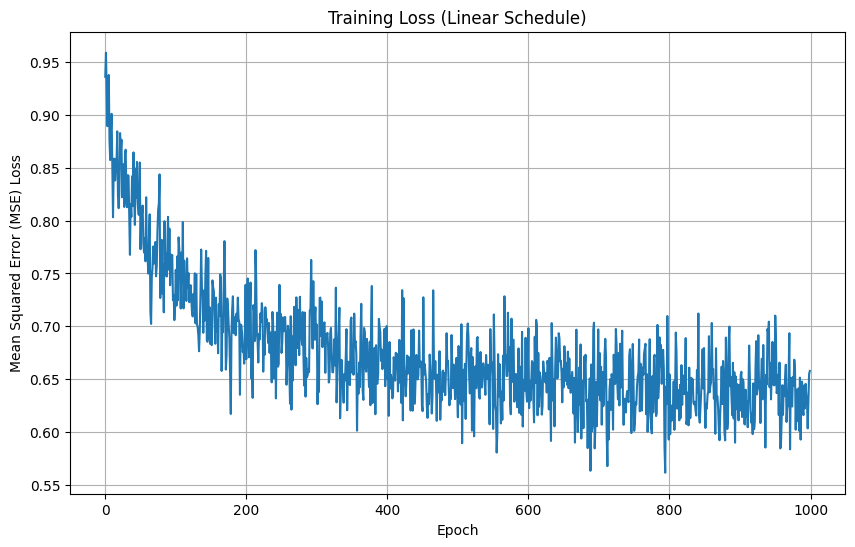


--- Generating Samples ---


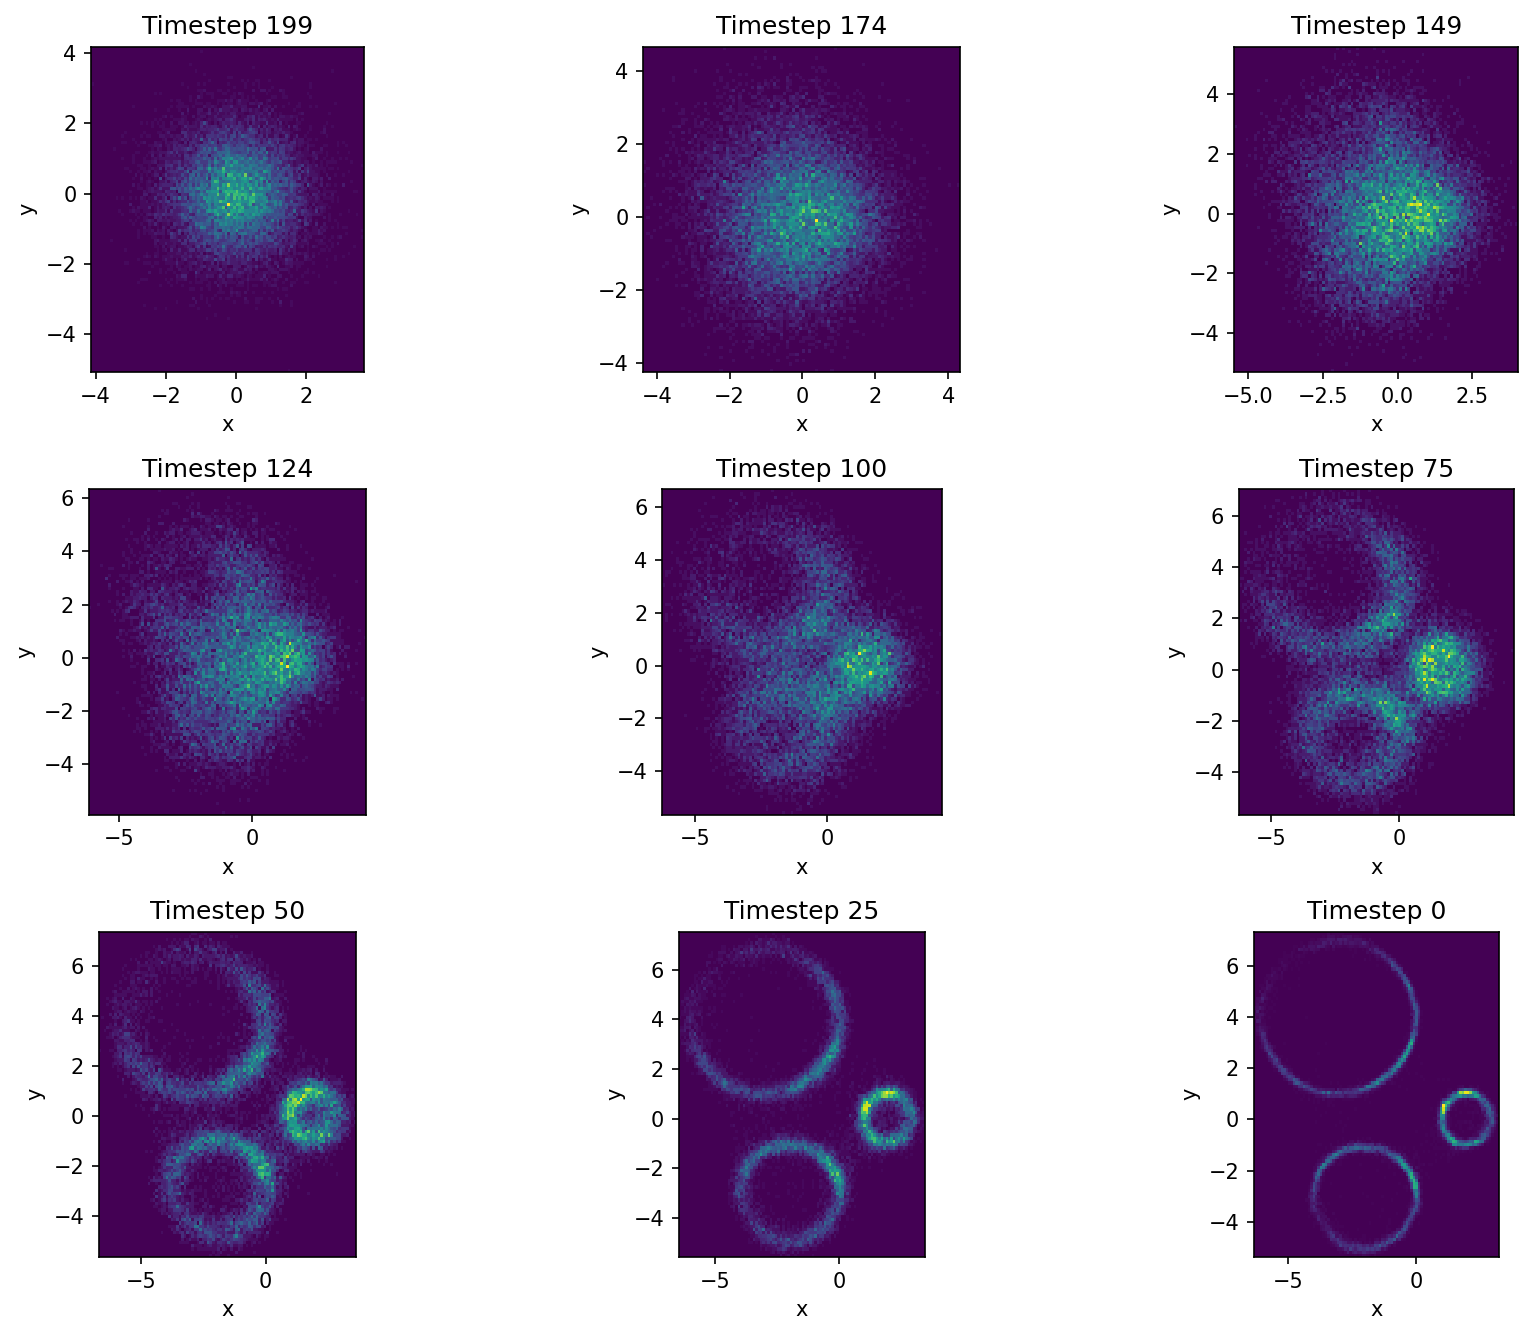


--- Evaluating Distributions ---
--- 1. Visual Check: Manifold vs. Memorization ---


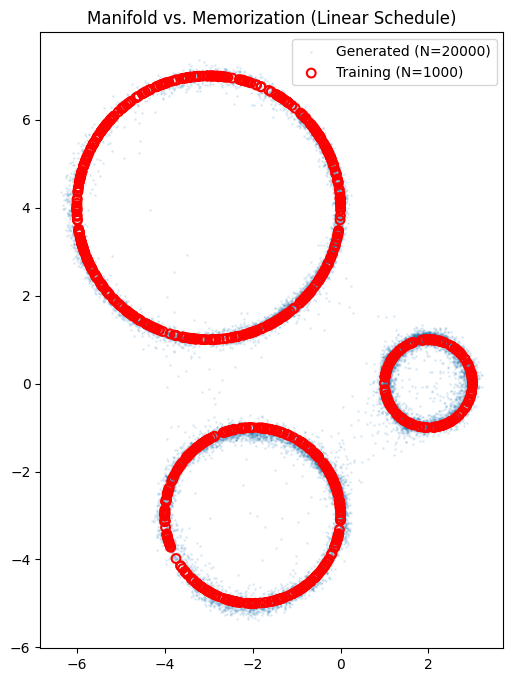


--- 2. Quantitative Check: Metrics vs. Ground Truth ---
Calculating SWD between 20000 truth and 20000 generated samples...
  Sliced Wasserstein Distance: 1.387738
  KL Divergence (Gen || Truth): 7.388463
  KL Divergence (Truth || Gen): 1.416360
  JS Divergence: 0.395436


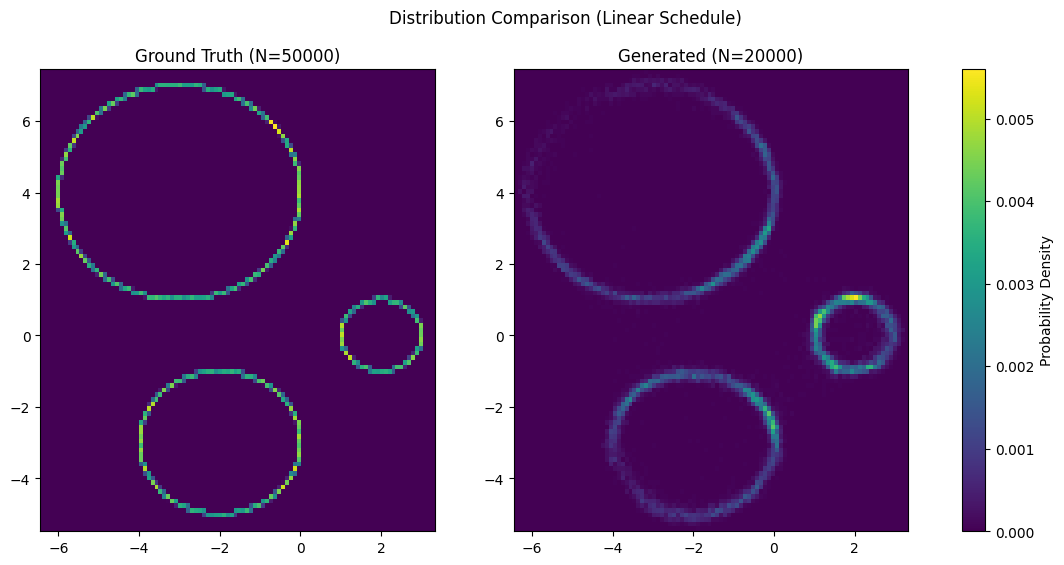


--- 3. Stochastic Trajectory Plot (Item 11) ---


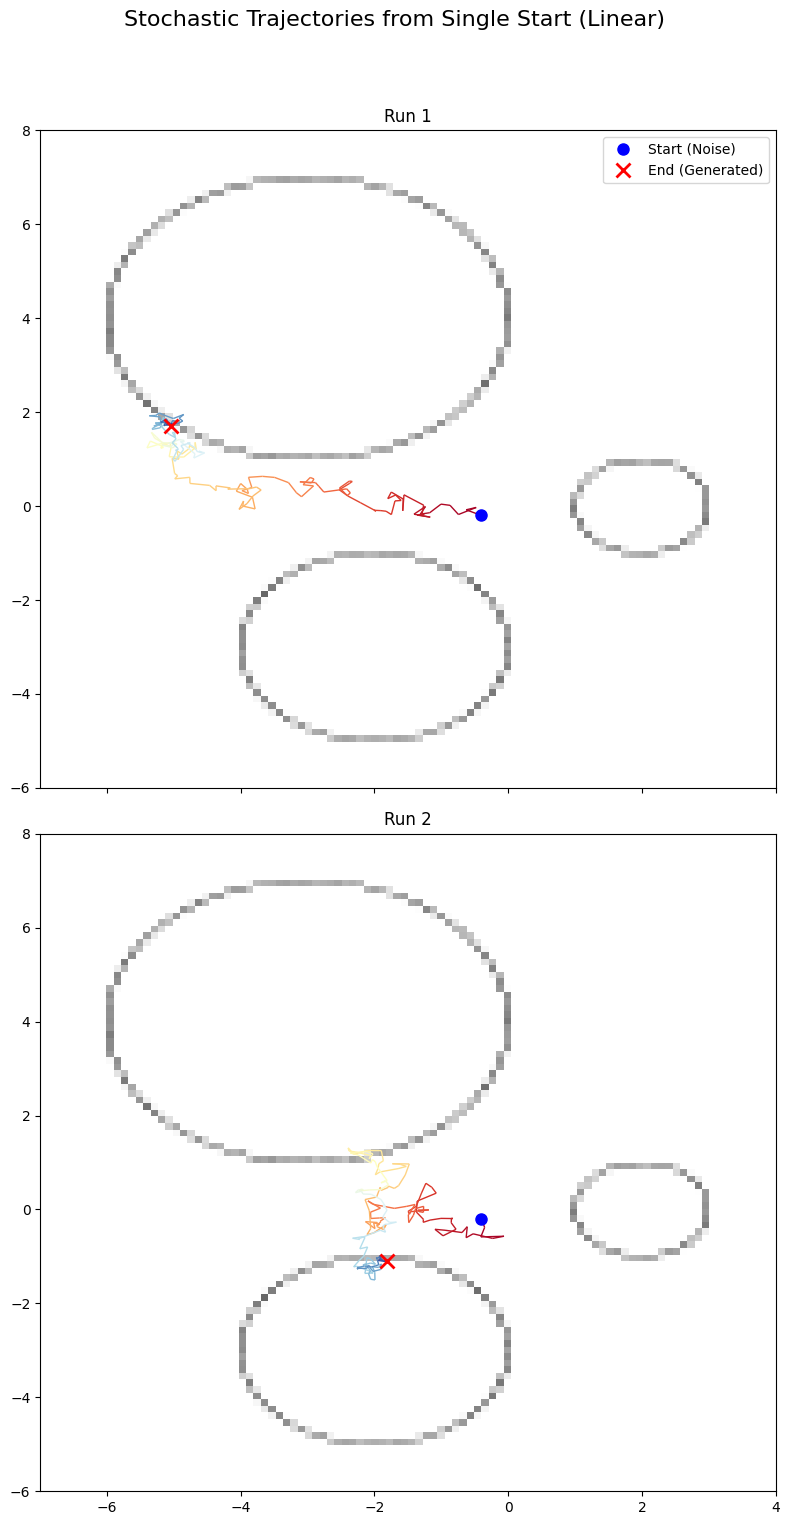


  FINISHED EXPERIMENT: LINEAR



  STARTING EXPERIMENT: COSINE SCHEDULE
  Training on 1000 samples for 1000 epochs.
  Evaluating against 50000 ground truth samples.

Epoch 1/1000, Loss: 0.883241
Epoch 200/1000, Loss: 0.618111
Epoch 400/1000, Loss: 0.616194
Epoch 600/1000, Loss: 0.528208
Epoch 800/1000, Loss: 0.555651
Epoch 1000/1000, Loss: 0.539671


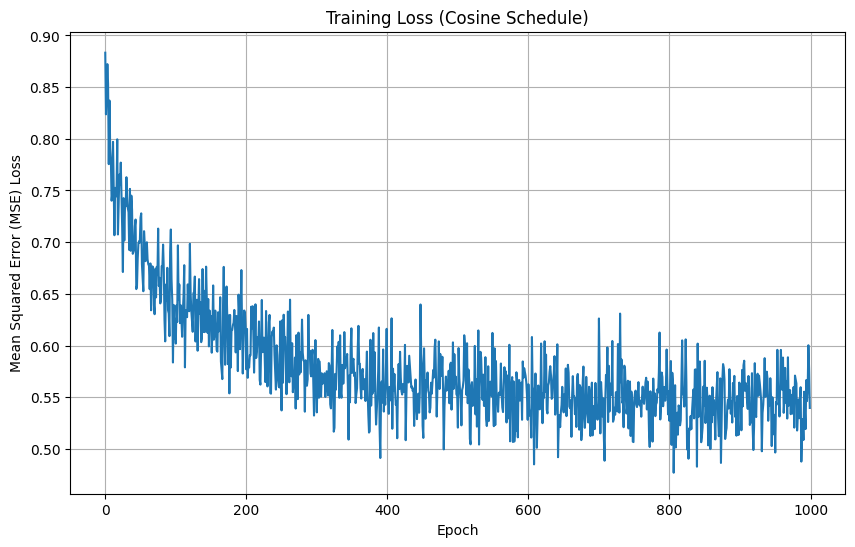


--- Generating Samples ---


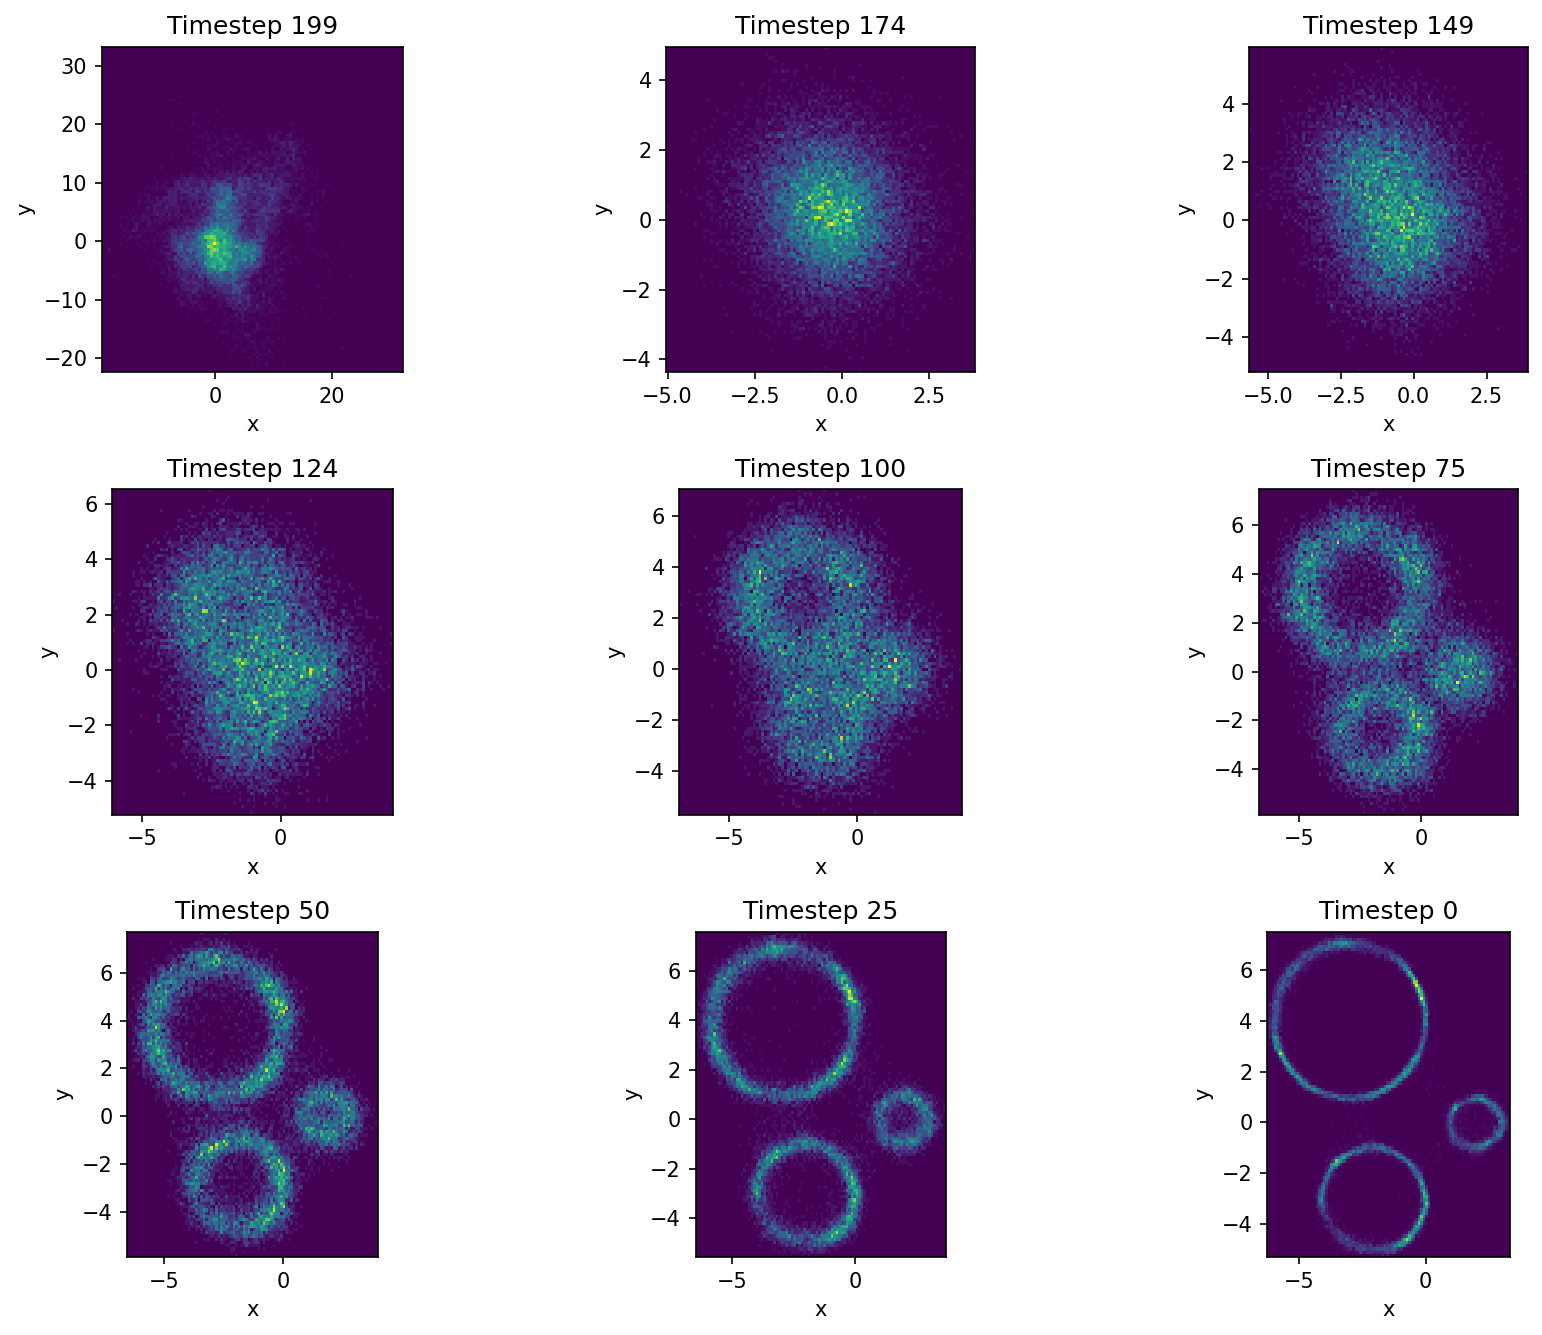


--- Evaluating Distributions ---
--- 1. Visual Check: Manifold vs. Memorization ---


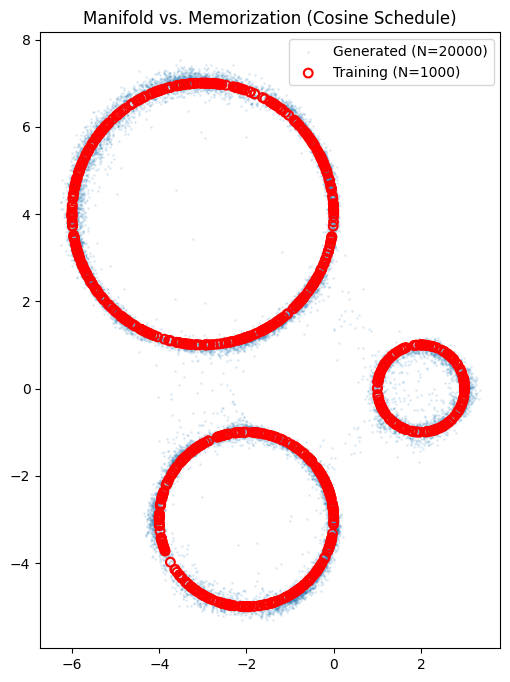


--- 2. Quantitative Check: Metrics vs. Ground Truth ---
Calculating SWD between 20000 truth and 20000 generated samples...
  Sliced Wasserstein Distance: 0.146792
  KL Divergence (Gen || Truth): 7.867566
  KL Divergence (Truth || Gen): 0.982451
  JS Divergence: 0.386422


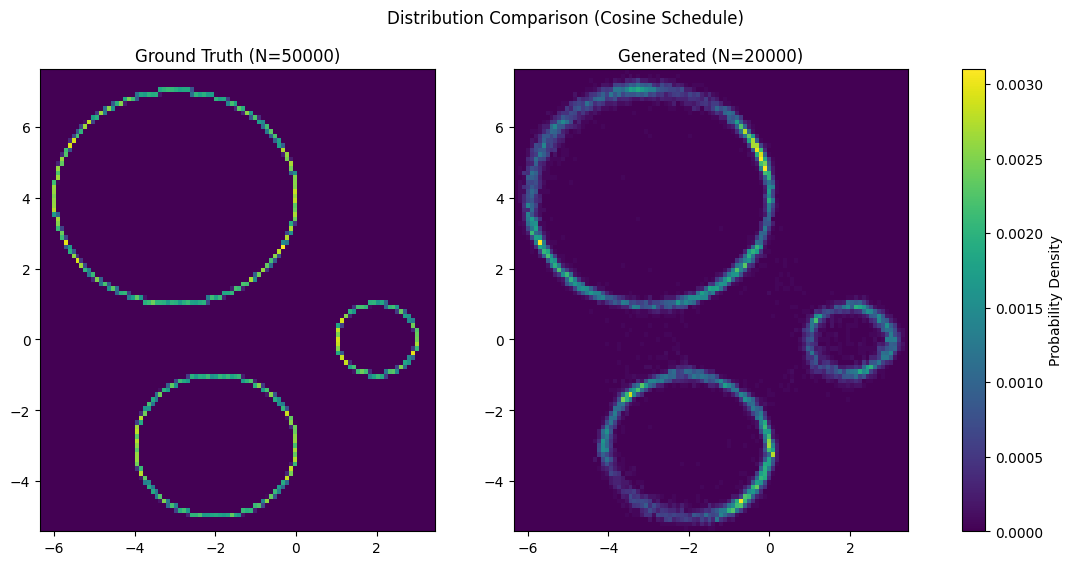


--- 3. Stochastic Trajectory Plot (Item 11) ---


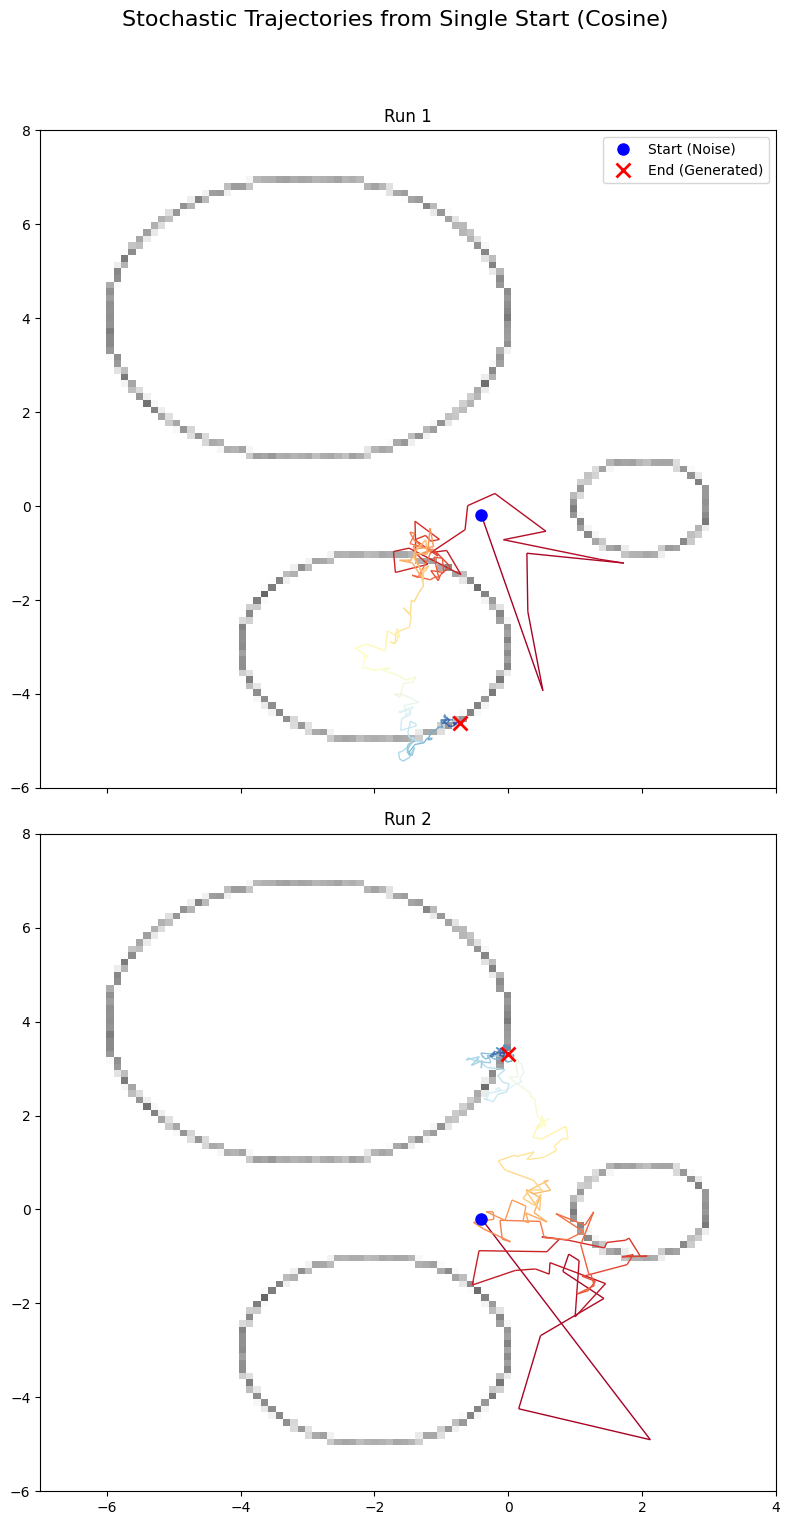


  FINISHED EXPERIMENT: COSINE




In [23]:
all_results = {}

# --- Experiment 1: Linear Schedule ---
lin_model, lin_metrics = train_and_evaluate(
    schedule_type='linear',
    X_train=X_train_tensor,
    X_truth=X_truth_tensor,
    T=T, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, lr=LR
)
all_results['linear'] = lin_metrics


# --- Experiment 2: Cosine Schedule ---
cos_model, cos_metrics = train_and_evaluate(
    schedule_type='cosine',
    X_train=X_train_tensor,
    X_truth=X_truth_tensor,
    T=T, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, lr=LR
)
all_results['cosine'] = cos_metrics


 ### 7. Final Comparison (Item 10)

--- FINAL METRIC COMPARISON ---
Metric        | Linear        | Cosine
--------------|---------------|--------------
SWD           | 1.387738      | 0.146792      
KL            | 7.388463      | 7.867566      
KL 2          | 1.416360      | 0.982451      
JSD           | 0.395436      | 0.386422      


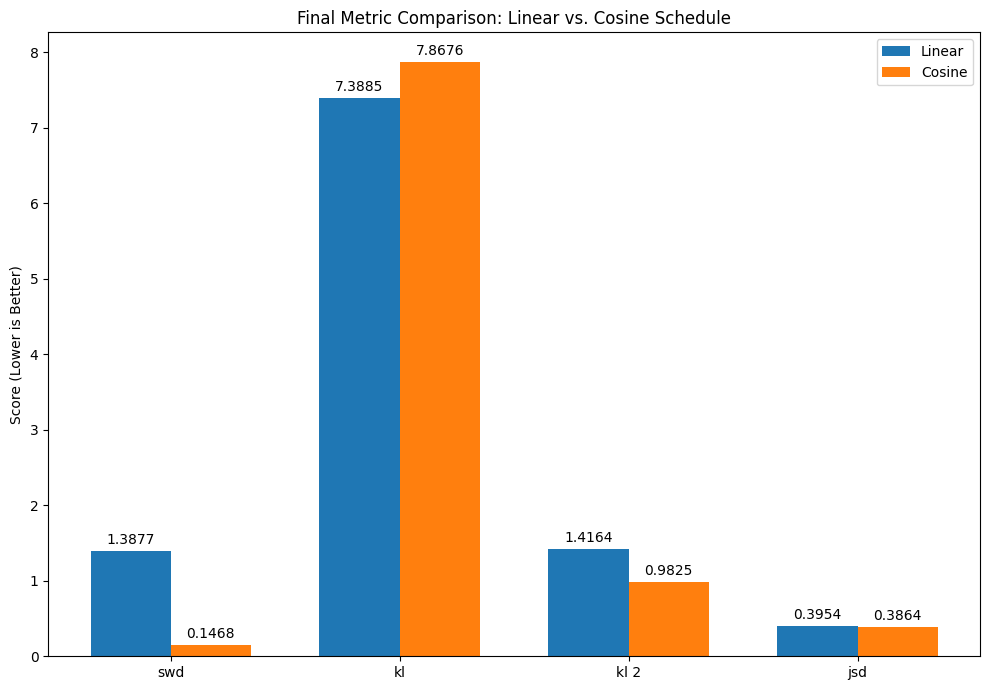

In [24]:
print("--- FINAL METRIC COMPARISON ---")

labels = list(all_results['linear'].keys())
linear_scores = list(all_results['linear'].values())
cosine_scores = list(all_results['cosine'].values())

print(f"Metric        | Linear        | Cosine")
print(f"--------------|---------------|--------------")
for i, label in enumerate(labels):
    print(f"{label.upper():<14}| {linear_scores[i]:<14.6f}| {cosine_scores[i]:<14.6f}")

# --- Final Bar Chart ---
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, linear_scores, width, label='Linear')
rects2 = ax.bar(x + width/2, cosine_scores, width, label='Cosine')

ax.set_ylabel('Score (Lower is Better)')
ax.set_title('Final Metric Comparison: Linear vs. Cosine Schedule')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.4f')
ax.bar_label(rects2, padding=3, fmt='%.4f')

fig.tight_layout()
plt.savefig(os.path.join(output_dir, "final_comparison.png"), dpi=300)
plt.show()